# Задание лабораторной работы

- Выберите набор данных (датасет) для решения задачи классификации или регрессии.
- В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
- С использованием метода train_test_split разделите выборку на обучающую и тестовую.
- Обучите следующие модели: одну из линейных моделей (линейную или полиномиальную регрессию при решении задачи регрессии, логистическую регрессию при решении задачи классификации); SVM; дерево решений.
- Оцените качество моделей с помощью двух подходящих для задачи метрик. Сравните качество полученных моделей.
- Постройте график, показывающий важность признаков в дереве решений.
- Визуализируйте дерево решений или выведите правила дерева решений в текстовом виде.

## Выбор и загрузка данных

В качестве датасета будем использовать набор данных, содержащий данные по зарплатам и опыта работы.

Набор данных имеет следующие атрибуты:

- Salary
- YearsExperience

### Импорт библиотек

Импортируем библиотеки с помощью команды import:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
sns.set(style="ticks")

### Загрузка данных

Загрузим набор данных:

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# data = pd.read_csv('/content/drive/My Drive/Car_sales.csv', sep=",")
data = pd.read_csv('Salary_dataset.csv')

## Первичный анализ и обработка данных

Выведем первые 5 строк датасета:

In [3]:
data.head()

,Unnamed: 0,YearsExperience,Salary
0,0,1.2,39344.0
1,1,1.4,46206.0
2,2,1.6,37732.0
3,3,2.1,43526.0
4,4,2.3,39892.0


Определим размер датасета:

In [4]:
data.shape

(30, 3)

Определим типы данных:

In [5]:
data.dtypes

Unnamed: 0           int64
YearsExperience    float64
Salary             float64
dtype: object

### Разделение выборки на обучающую и тестовую

Разделим выборку с помощью функции train_test_split:

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(np.array(pd.DataFrame({"tmp" : data['YearsExperience']})), np.array(data['Salary']), random_state=1)

Размеры обучающей выборки и тестовой выборки:

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((22, 1), (22,), (8, 1), (8,))

## Обучение моделей

### Линейная модель регрессии

Построим корреляционную матрицу для выявления линейной зависимости:

<Axes: >

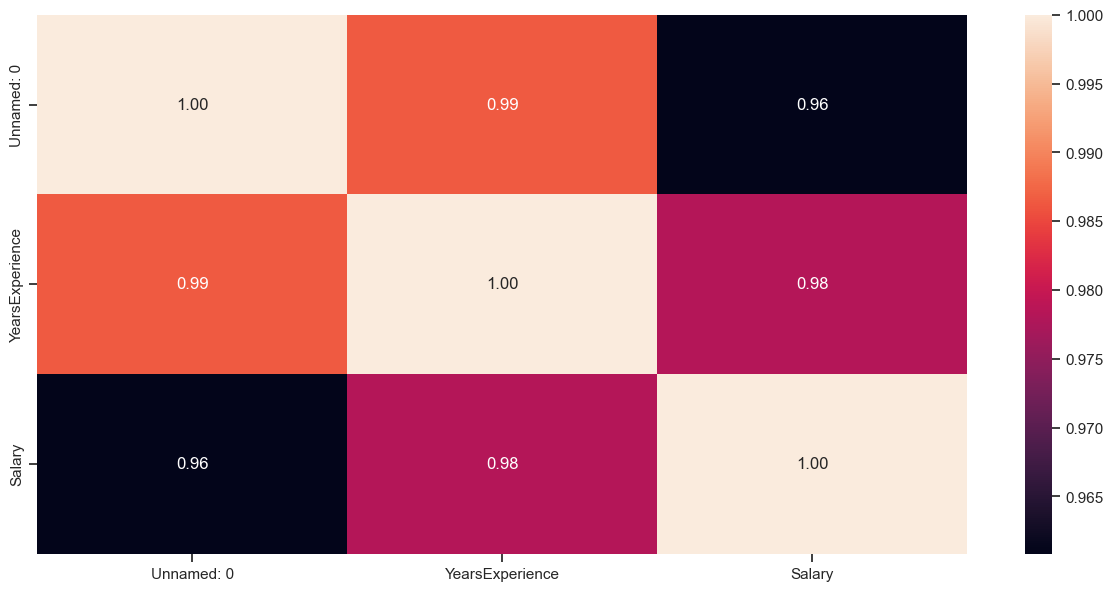

In [9]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(data.corr(method='pearson'), ax=ax, annot=True, fmt='.2f')

<Axes: xlabel='YearsExperience', ylabel='Salary'>

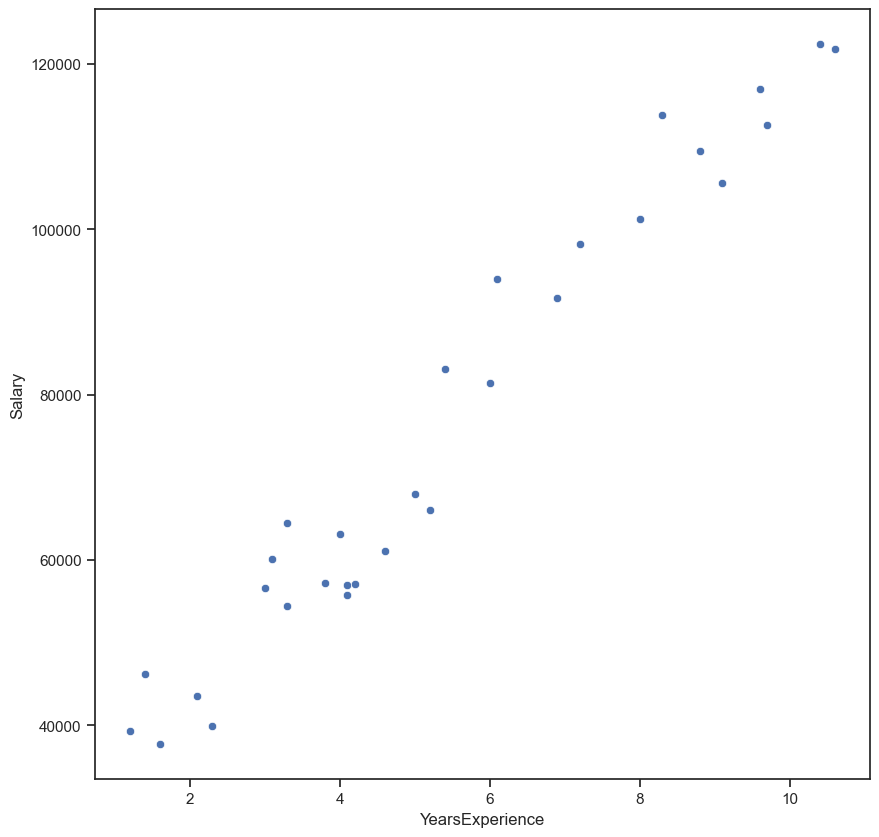

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(ax=ax, x='YearsExperience', y='Salary', data=data)

Между признаками "Salary" и "YearsExperience" прослеживается линейная зависимость (коэффициент корреляции = 0.98).

#### Аналитическое вычисление коэффициентов регрессии

In [11]:
from typing import Dict, Tuple

In [12]:
def analytic_regr_coef(x_array : np.ndarray,
                       y_array : np.ndarray) -> Tuple[float, float]:
    x_mean = np.mean(x_array)
    y_mean = np.mean(y_array)
    var1 = np.sum([(x-x_mean)**2 for x in x_array])
    cov1 = np.sum([(x-x_mean)*(y-y_mean) for x, y in zip(x_array, y_array)])
    b1 = cov1 / var1
    b0 = y_mean - b1*x_mean
    return b0, b1

In [13]:
x_array = data['YearsExperience'].values
y_array = data['Salary'].values

Коэффициенты регрессии:

In [14]:
b0, b1 = analytic_regr_coef(x_array, y_array)
b0, b1

(24848.2039665232, 9449.962321455076)

Отрисовка зависимости:

In [15]:
def y_regr(x_array : np.ndarray, b0: float, b1: float) -> np.ndarray:
    res = [b1*x+b0 for x in x_array]
    return res

In [16]:
regr_a = y_regr(x_array, b0, b1)

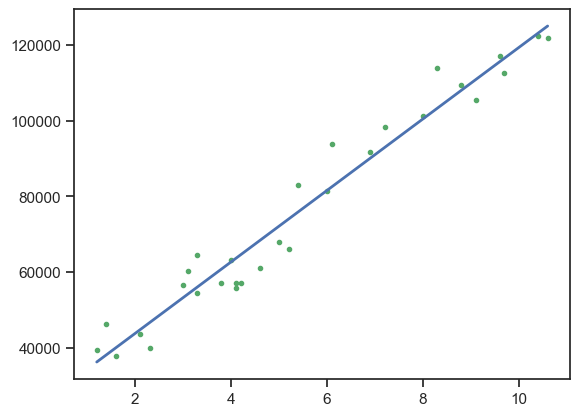

In [17]:
plt.plot(x_array, y_array, 'g.')
plt.plot(x_array, regr_a, 'b', linewidth=2.0)
plt.show()

#### Метод наименьших квадратов

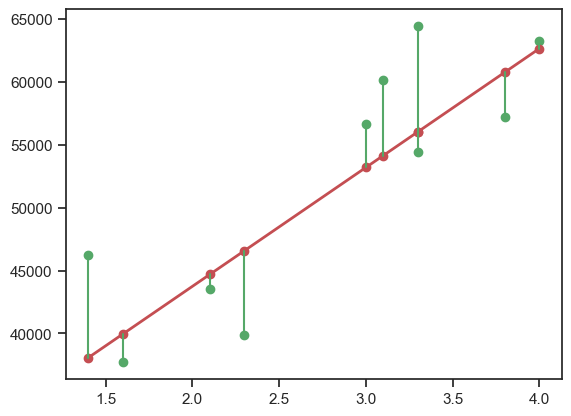

In [18]:
K_mnk=10

plt.plot(x_array[1:K_mnk+1], y_array[1:K_mnk+1], 'go')
plt.plot(x_array[1:K_mnk+1], regr_a[1:K_mnk+1], '-ro', linewidth=2.0)

for i in range(len(x_array[1:K_mnk+1])):
    x1 = x_array[1:K_mnk+1][i]
    y1 = y_array[1:K_mnk+1][i]
    y2 = regr_a[1:K_mnk+1][i]
    plt.plot([x1,x1],[y1,y2],'g-')

plt.show()

Зеленые отрезки - ошибки между истинными и предсказанными значениями.

#### Решение задачи оптимизации - градиентный спуск

In [19]:
from sklearn.metrics import mean_squared_error

In [20]:
def gradient_descent(x_array : np.ndarray,
                     y_array : np.ndarray,
                     b0_0 : float,
                     b1_0 : float,
                     epochs : int,
                     learning_rate : float = 0.001
                    ) -> Tuple[float, float]:
    b0, b1 = b0_0, b1_0
    k = float(len(x_array))
    for i in range(epochs):
        y_pred = b1 * x_array + b0
        dL_db1 = (-2/k) * np.sum(np.multiply(x_array, (y_array - y_pred)))
        dL_db0 = (-2/k) * np.sum(y_array - y_pred)
        b1 = b1 - learning_rate * dL_db1
        b0 = b0 - learning_rate * dL_db0
    y_pred = b1 * x_array + b0
    return b0, b1, y_pred

In [21]:
def show_gradient_descent(epochs, b0_0, b1_0):
    grad_b0, grad_b1, grad_y_pred = gradient_descent(x_array, y_array, b0_0, b1_0, epochs)
    print('b0 = {} - (теоретический), {} - (градиентный спуск)'.format(b0, grad_b0))
    print('b1 = {} - (теоретический), {} - (градиентный спуск)'.format(b1, grad_b1))
    print('MSE = {}'.format(mean_squared_error(regr_a, grad_y_pred)))
    plt.plot(x_array, y_array, 'g.')
    plt.plot(x_array, regr_a, 'b', linewidth=2.0)
    plt.plot(x_array, grad_y_pred, 'r', linewidth=2.0)
    plt.show()

b0 = 24848.2039665232 - (теоретический), 152.008 - (градиентный спуск)
b1 = 9449.962321455076 - (теоретический), 970.0088266666668 - (градиентный спуск)
MSE = 5544330247.686615


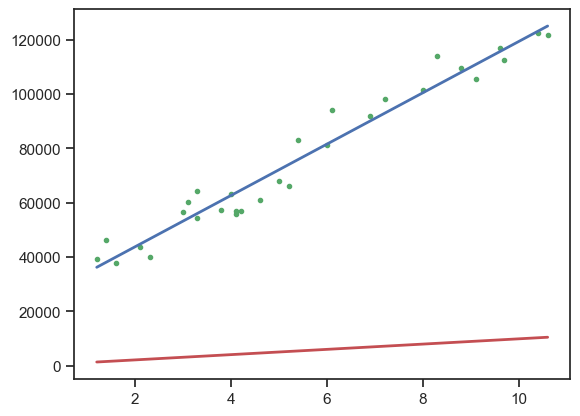

In [22]:
show_gradient_descent(1, 0, 0)

Добьемся сходимости алгоритма путем задания других коэффициентов:

b0 = 24848.2039665232 - (теоретический), 2806.1566987609963 - (градиентный спуск)
b1 = 9449.962321455076 - (теоретический), 12680.043562546041 - (градиентный спуск)
MSE = 101987899.44018738


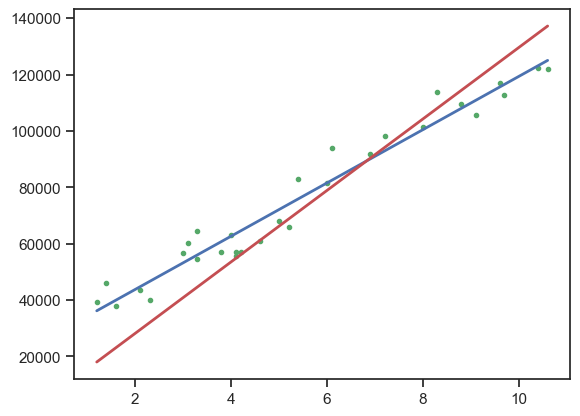

In [23]:
show_gradient_descent(100, -2.98, -22)

#### Подбор коэффициентов через LinearRegression

In [24]:
from sklearn.linear_model import LinearRegression

Коэффициенты, полученные с использованием LinearRegression:

In [25]:
regr1 = LinearRegression().fit(x_array.reshape(-1, 1), y_array.reshape(-1, 1))
(b1, regr1.coef_), (b0, regr1.intercept_)

((9449.962321455076, array([[9449.96232146]])),
 (24848.2039665232, array([24848.20396652])))

Линейная модель:

In [26]:
model1 = LinearRegression()
model1.fit(X_train, y_train)

LinearRegression()

#### Стохастический градиентный спуск с использованием SGDRegressor

In [27]:
from sklearn.linear_model import SGDRegressor

Коэффициенты, найденные с использованием SGDRegressor:

In [28]:
regr2 = SGDRegressor().fit(x_array.reshape(-1, 1), y_array)
(b1, regr2.coef_), (b0, regr2.intercept_)

((9449.962321455076, array([10921.60786203])),
 (24848.2039665232, array([14531.76059704])))

Линейная модель, построенная в этом случае:

In [29]:
model2 = SGDRegressor()
model2.fit(X_train, y_train)

SGDRegressor()

#### L1-регуляризация линейной модели

In [30]:
from sklearn.linear_model import Lasso

Коэффициенты, полученные с использованием Lasso:

In [31]:
regr3 = Lasso().fit(x_array.reshape(-1, 1), y_array)
(b1, regr3.coef_), (b0, regr3.intercept_)

((9449.962321455076, array([9449.83387187])),
 (24848.2039665232, 24848.899306943145))

Линейная модель:

In [32]:
model3 = Lasso()
model3.fit(X_train, y_train)

Lasso()

### SVM модель

Будем использовать класс SVR для решения задачи регрессии методом опорных векторов:

In [33]:
from sklearn.svm import SVR

Модель SVM:

In [34]:
regr4 = SVR(kernel='linear', C=1.0)
model4 = regr4.fit(X_train, y_train)

### Дерево решений

In [35]:
from sklearn.tree import DecisionTreeRegressor

In [36]:
def stat_tree(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("Всего узлов:", n_nodes)
    print("Листовых узлов:", sum(is_leaves))
    print("Глубина дерева:", max(node_depth))
    print("Минимальная глубина листьев дерева:", min(node_depth[is_leaves]))
    print("Средняя глубина листьев дерева:", node_depth[is_leaves].mean())

Построим модель дерева с глубиной = 3:

In [37]:
regr5 = DecisionTreeRegressor(max_depth=3)
model5 = regr5.fit(X_train, y_train)

Выведем основную статистику для дерева:

In [38]:
stat_tree(model5)

Всего узлов: 15
Листовых узлов: 8
Глубина дерева: 3
Минимальная глубина листьев дерева: 3
Средняя глубина листьев дерева: 3.0


И с глубиной = 5:

In [39]:
regr6 = DecisionTreeRegressor(max_depth=5)
model6 = regr6.fit(X_train, y_train)

In [40]:
stat_tree(model6)

Всего узлов: 29
Листовых узлов: 15
Глубина дерева: 5
Минимальная глубина листьев дерева: 3
Средняя глубина листьев дерева: 4.133333333333334


Визуализация деревьев, а также их правила представлены в пункте 6.

## Оценка качества моделей с помощью двух метрик. Сравнение качества.

Оценивать качество регрессии будем при помощи двух метрик - средней абсолютной ошибки (Mean Absolute Error) и медианной абсолютной ошибки (Median Absolute Error):

In [41]:
from sklearn.metrics import mean_absolute_error, median_absolute_error

In [42]:
err1 = []
err2 = []

Сформируем функцию для оценивания:

In [43]:
def rate_model(model):
    print("Средняя абсолютная ошибка:",
          mean_absolute_error(y_test, model.predict(X_test)))
    err1.append(mean_absolute_error(y_test, model.predict(X_test)))
    print("Медианная абсолютная ошибка:",
          median_absolute_error(y_test, model.predict(X_test)))
    err2.append(median_absolute_error(y_test, model.predict(X_test)))

In [44]:
rate_model(model1)

Средняя абсолютная ошибка: 5215.553722712967
Медианная абсолютная ошибка: 4775.078867444594


In [45]:
rate_model(model2)

Средняя абсолютная ошибка: 5353.565260298075
Медианная абсолютная ошибка: 4005.1940172661634


In [46]:
rate_model(model3)

Средняя абсолютная ошибка: 5215.712354139012
Медианная абсолютная ошибка: 4775.359180004671


In [47]:
rate_model(model4)

Средняя абсолютная ошибка: 24046.211250007153
Медианная абсолютная ошибка: 24961.215000014305


In [48]:
rate_model(model5)

Средняя абсолютная ошибка: 8214.375
Медианная абсолютная ошибка: 5659.0


In [49]:
rate_model(model6)

Средняя абсолютная ошибка: 7728.3125
Медианная абсолютная ошибка: 5409.25


Чем ближе значение средней абсолютной ошибки и медианной абсолютной ошибки к нулю, тем лучше качество регрессии.

Самая лучшая по качеству по обоим метрикам - первая модель, полученная при помощи LinearRegression, а худшая - полученная через SGDRegressor.

Визуальное представление оценки:

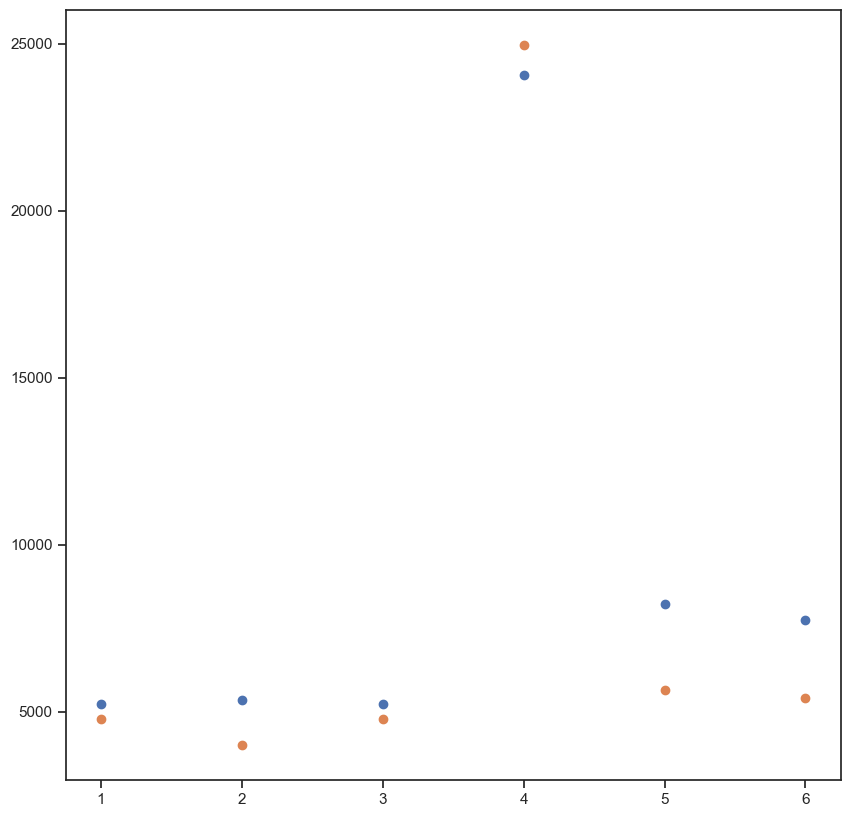

In [50]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter([1, 2, 3, 4, 5, 6], err1)
plt.scatter([1, 2, 3, 4, 5, 6], err2)

In [51]:
err1.pop(1)
err2.pop(1)

4005.1940172661634

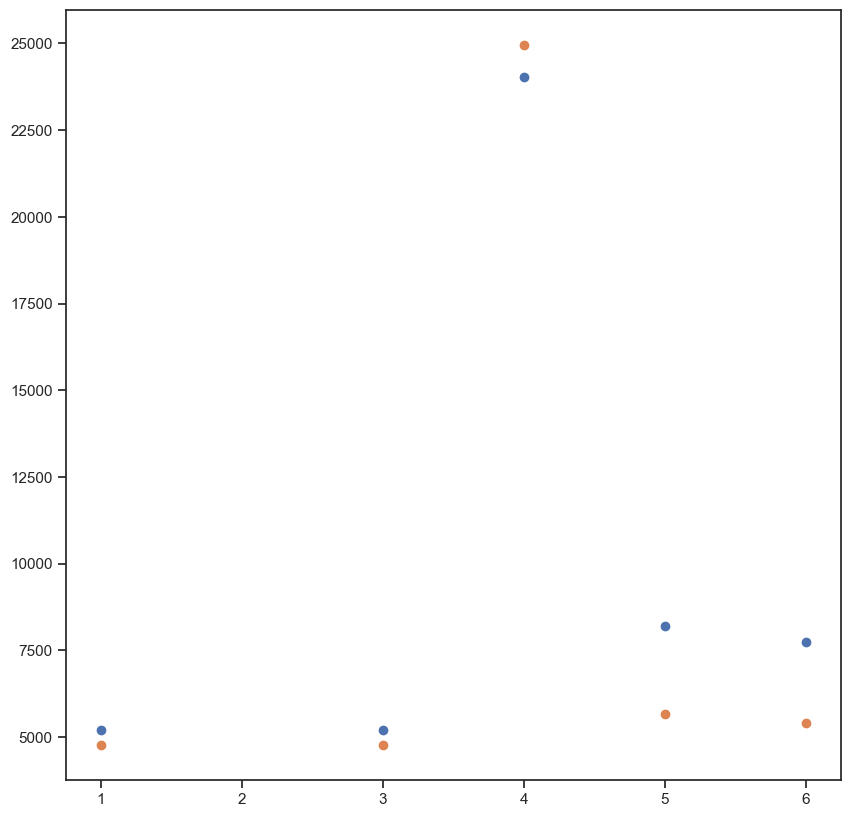

In [52]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter([1, 3, 4, 5, 6], err1)
plt.scatter([1, 3, 4, 5, 6], err2)

## График важности признаков в дереве решений

Вычисление важности признаков основано на том, какое количество раз признак встречается в условиях дерева:

In [53]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(18,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

Проверим для модели с глубиной = 3:

In [54]:
list(zip(data['YearsExperience'], model5.feature_importances_))

[(1.2000000000000002, 1.0)]

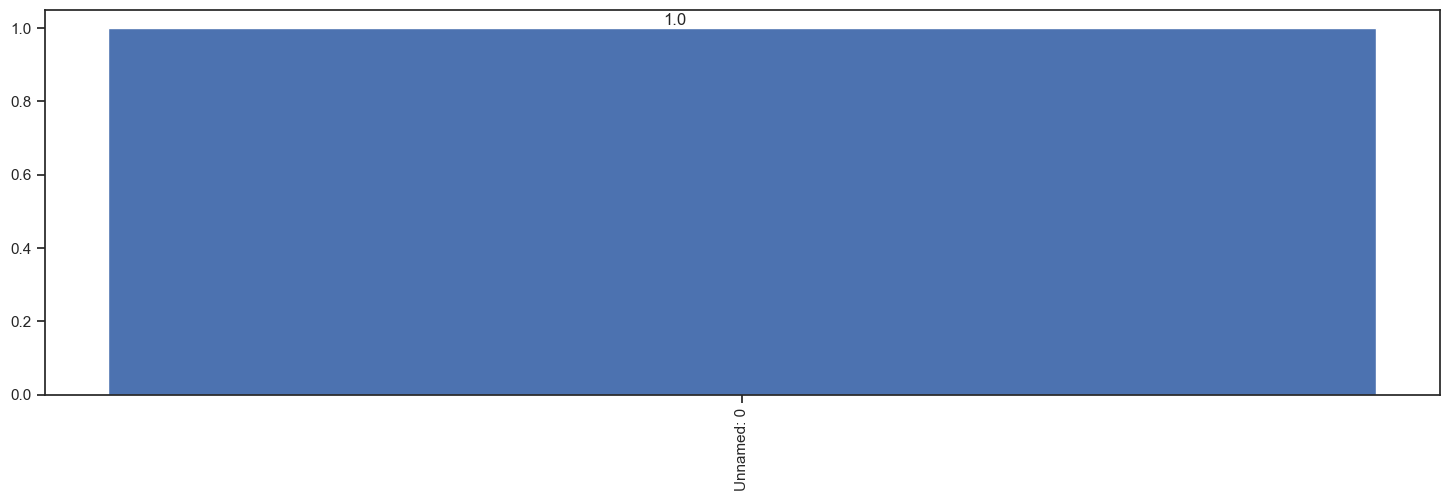

In [55]:
sal_tree_cl_fl_1, sal_tree_cl_fd_1 = draw_feature_importances(model5, data)

И для модели с глубиной = 5:

In [56]:
list(zip(data.columns.values, model6.feature_importances_))

[('Unnamed: 0', 1.0)]

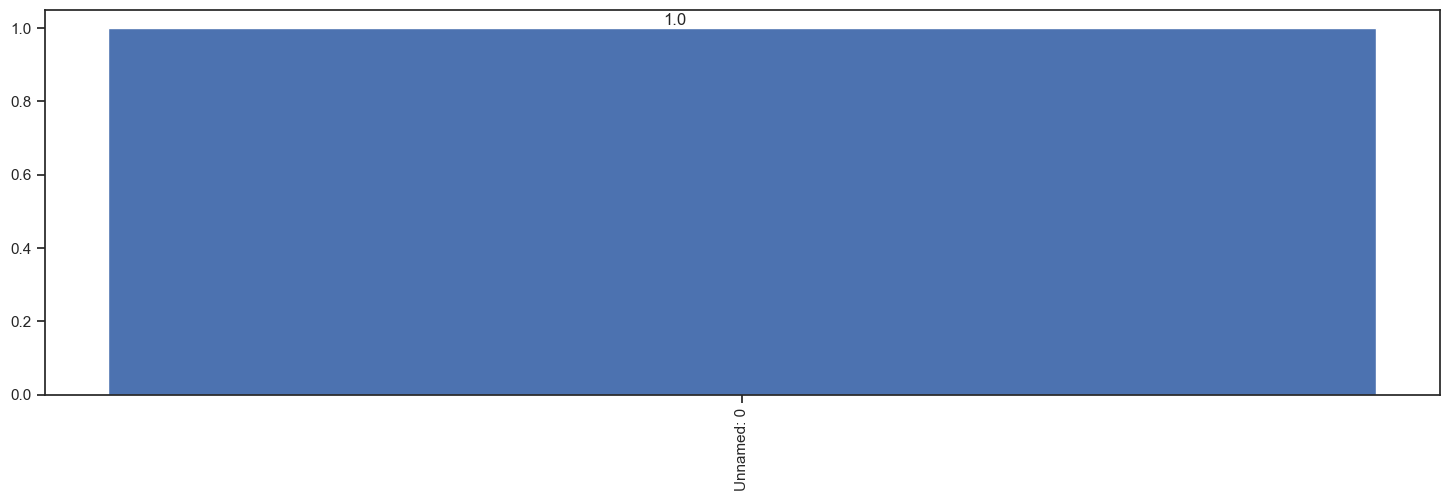

In [57]:
sal_tree_cl_fl_2, sal_tree_cl_fd_ = draw_feature_importances(model6, data)

## Визуализация деревьев решений и его правила

In [58]:
! pip install pydotplus

Defaulting to user installation because normal site-packages is not writeable


In [59]:
from io import StringIO
from IPython.display import Image
import graphviz
import pydotplus
from sklearn.tree import export_graphviz

In [60]:
%pip install graphviz

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



### Визуализация деревьев

In [61]:
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

Визуализируем дерево с глубиной = 3:

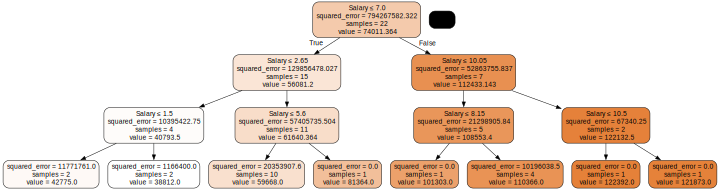

In [62]:
dot_data = export_graphviz(model5, out_file=None,
                           feature_names=['Salary'], # Используем список с одним элементом для одного признака
                           class_names=data['YearsExperience'].unique().tolist(),
                           filled=True, rounded=True, special_characters=True)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size(10)
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

In [72]:
# Создание объекта Graphviz из строки DOT
gvz_graph = graphviz.Source(dot_data)

# Сохранение графа в файл PNG
gvz_graph.render(filename='tree', format='png', cleanup=True)

'tree.png'

И с глубиной = 5:

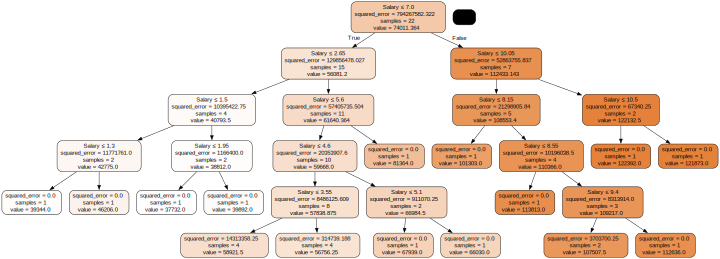

In [68]:
dot_data = export_graphviz(model6, out_file=None,
                           feature_names=['Salary'], # Используем список с одним элементом для одного признака
                           class_names=data['YearsExperience'].unique().tolist(),
                           filled=True, rounded=True, special_characters=True)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size(10)
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

In [71]:
# Создание объекта Graphviz из строки DOT
gvz_graph = graphviz.Source(dot_data)

# Сохранение графа в файл PNG
gvz_graph.render(filename='tree5', format='png', cleanup=True)

'tree5.png'

### Вывод правил дерева

Выведем правила для дерева с глубиной = 3:

In [73]:
from IPython.core.display import HTML
from sklearn.tree import export_text
tree_rules = export_text(model5, feature_names=['Salary'])
HTML('<pre>' + tree_rules + '</pre>')

И для дерева с глубиной = 5:

In [74]:
from IPython.core.display import HTML
from sklearn.tree import export_text
tree_rules = export_text(model6, feature_names=['Salary'])
HTML('<pre>' + tree_rules + '</pre>')